In [18]:
import pandas as pdÍ
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.head()

,requests,memory,cpu,timestamp
0,6.0,0.105,0.003,2023-10-01 00:00:00
1,29.0,0.104,0.004,2023-10-01 00:01:00
2,12.0,0.105,0.003,2023-10-01 00:02:00
3,18.0,0.105,0.004,2023-10-01 00:03:00
4,4.0,0.105,0.003,2023-10-01 00:04:00


In [38]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])

# Ensure data is sorted by timestamp
df = df.sort_values(by="timestamp").reset_index(drop=True)

# Select relevant columns
target_col = "requests"
feature_cols = ["memory", "cpu"]

# Normalize features
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

df[feature_cols] = scaler_x.fit_transform(df[feature_cols])
df[target_col] = scaler_y.fit_transform(df[[target_col]])

# Convert DataFrame to NumPy array
data = df[["requests", "memory", "cpu"]].values


In [43]:
data.shape

(1440, 3)

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len=12, pred_len=12):  # Increased input_len to avoid lag errors
        self.data = data
        self.input_len = input_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.input_len - self.pred_len

    def __getitem__(self, index):
        past_values = self.data[index : index + self.input_len]
        future_values = self.data[index + self.input_len : index + self.input_len + self.pred_len]
        
        # Create a binary mask (1 for observed values)
        past_observed_mask = np.ones_like(past_values)

        # Extract time features (e.g., normalized time step indices)
        past_time_features = np.expand_dims(np.arange(self.input_len) / self.input_len, axis=1)

        return (
            torch.tensor(past_values, dtype=torch.float32),
            torch.tensor(past_time_features, dtype=torch.float32),
            torch.tensor(past_observed_mask, dtype=torch.float32),
            torch.tensor(future_values, dtype=torch.float32),
        )

In [40]:
# Define sequence lengths
input_len = 24  # Increased to avoid lag-related errors
pred_len = 12   # Forecasting 12 time steps ahead


# Create dataset
dataset = TimeSeriesDataset(data, input_len, pred_len)
# Create DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

In [41]:
len(dataset)

1404

In [ ]:
for batch in train_loader:
    print(f"Batch length: {len(batch)}")  # Should print 4
    print(f"past_values shape: {batch[0].shape}")  # (batch_size, input_len, features)
    print(f"past_time_features shape: {batch[1].shape}")  
    print(f"past_observed_mask shape: {batch[2].shape}")  
    print(f"future_values shape: {batch[3].shape}")  
    break  # Only print once


Batch length: 4
past_values shape: torch.Size([16, 112, 3])
past_time_features shape: torch.Size([16, 112, 1])
past_observed_mask shape: torch.Size([16, 112, 3])
future_values shape: torch.Size([16, 12, 3])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import AutoformerConfig, AutoformerModel

# Define model configuration
config = AutoformerConfig(
    prediction_length=pred_len,
    context_length=input_len,  
    input_size=len(feature_cols),  
    lags_sequence=[1, 2, 3, 4],  # Manually define lags (must be <= context_length)
)

# Initialize model
model = AutoformerModel(config).to(device)


In [ ]:
model.parameters()

<generator object Module.parameters at 0x788f9c257ae0>

In [ ]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for past_values, past_time_features, past_observed_mask, future_values in train_loader:
        past_time_features, past_observed_mask, past_values = (
            past_time_features.to(device),
            past_observed_mask.to(device),
            past_values.to(device),
        )

        # print(past_time_features.shape)
        print("mask: ", past_observed_mask.shape)
        optimizer.zero_grad()
        
        # Forward pass (passing correct inputs)
        outputs = model(
            past_time_features=past_time_features,
            past_observed_mask=past_observed_mask,
            past_values=past_values
        ).last_hidden_state  # Extract predictions

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


mask:  torch.Size([16, 112, 3])


ValueError: lags cannot go further than history length, found lag 4 while history length is only 112

### Demo

In [32]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoformerConfig, AutoformerForPrediction, Trainer, TrainingArguments

In [14]:
df = pd.read_csv("preprocessed_dataset.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])

input_features = ['memory', 'cpu']
target_feature = 'requests'

In [43]:
scaler = MinMaxScaler()
df[input_features + [target_feature]] = scaler.fit_transform(df[input_features + [target_feature]])

input_length = 48 
prediction_length = 24 

In [ ]:
# Create dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_length, prediction_length):
        self.data = df
        self.input_length = input_length
        self.prediction_length = prediction_length
        
    def __len__(self):
        return len(self.data) - self.input_length - self.prediction_length + 1
    
    def __getitem__(self, idx):
        past_values = self.data.loc[idx : idx + self.input_length, target_feature].values
        future_values = self.data.loc[idx + self.input_length : idx + self.input_length + self.prediction_length, target_feature].values
        past_time_features = self.data.loc[idx : idx + self.input_length, input_features].values.reshape(self.input_length, -1)
        future_time_features = self.data.loc[idx + self.input_length : idx + self.input_length + self.prediction_length, input_features].values.reshape(self.prediction_length, -1)
        past_observed_mask = np.ones_like(past_values)  # Assume all values are observed
        future_observed_mask = np.ones_like(future_values)  # Ensure correct shape
        static_real_features = np.zeros((1, 1))  # Ensure shape is (1,)
        static_categorical_features = np.zeros((1, 1))  # Added static categorical features

        return {
            "past_values": torch.tensor(past_values, dtype=torch.float32).unsqueeze(-1),  # Shape (61, 1)
            "future_values": torch.tensor(future_values, dtype=torch.float32).unsqueeze(-1),  # Shape (24, 1)
            "past_time_features": self.data.loc[idx : idx + self.input_length, input_features].values.reshape(-1, 124),  # Example adjustment
            "future_time_features": torch.tensor(future_time_features, dtype=torch.float32).unsqueeze(1),  # Shape (24, 2)
            "past_observed_mask": torch.tensor(past_observed_mask, dtype=torch.float32).unsqueeze(-1),  # Shape (61, 1)
            "future_observed_mask": torch.tensor(future_observed_mask, dtype=torch.float32).unsqueeze(-1),  # Shape (24, 1)
            "static_real_features": torch.tensor(static_real_features, dtype=torch.float32).expand(1, 1),  # Shape (1, 1)
            "static_categorical_features": torch.tensor(static_categorical_features, dtype=torch.float32).expand(1, 1),  # Shape (1, 1)
        }

In [27]:
# Create dataset and dataloader
dataset = TimeSeriesDataset(df, input_length, prediction_length)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [28]:
sample = dataset[0]  # Fetch first sample
for key, value in sorted(sample.items()):
    print(f"{key}  {value.shape}")


ValueError: cannot reshape array of size 124 into shape (61,newaxis)

In [29]:
# Load Autoformer model
config = AutoformerConfig(
    context_length=input_length,
    prediction_length=prediction_length,
    input_size=len(input_features),
    target_size=1
)
model = AutoformerForPrediction(config)

In [30]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=64,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

### Try 4

In [2]:
from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig.from_pretrained("kashif/autoformer-traffic-hourly")
model = AutoformerForPrediction.from_pretrained("kashif/autoformer-traffic-hourly")


config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/92.7k [00:00<?, ?B/s]

In [16]:
from transformers import PretrainedConfig



def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [13]:
config

AutoformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "AutoformerForPrediction"
  ],
  "attention_dropout": 0.1,
  "autocorrelation_factor": 3,
  "cardinality": [
    0
  ],
  "context_length": 48,
  "d_model": 16,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 47,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "label_length": 10,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    23,
    24,
    25,
    47,
    48,
    49,
    71,
    72,
    73,
    95,
    96,
    97,
    119,
    120,
    121,
    143,
    144,
    145,
    167,
    168,
    169,
    335,
    336,
    337,
    503,
    504,
    505,
    671,


In [14]:
test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

NameError: name 'create_backtest_dataloader' is not defined

### Try 5

In [46]:
from transformers import AutoformerConfig, AutoformerModel
from torch.utils.data import DataLoader


In [47]:
modelconfig = AutoformerConfig(prediction_length=24, input_size=2)
model = AutoformerModel(config)

In [23]:
df = pd.read_csv("preprocessed_dataset.csv")

In [51]:
df.columns

Index(['requests', 'memory', 'cpu', 'timestamp', 'datetime', 'time_idx'], dtype='object')

### Now find out the model.forward() parameters

In [52]:
df.tail()

,requests,memory,cpu,timestamp,datetime,time_idx
1435,0.400,0.629630,0.2,2023-10-01 23:55:00,2023-10-01 23:55:00,1696204500
1436,0.300,0.648148,0.2,2023-10-01 23:56:00,2023-10-01 23:56:00,1696204560
1437,0.150,0.648148,0.2,2023-10-01 23:57:00,2023-10-01 23:57:00,1696204620
1438,0.325,0.629630,0.2,2023-10-01 23:58:00,2023-10-01 23:58:00,1696204680
1439,0.050,0.629630,0.2,2023-10-01 23:59:00,2023-10-01 23:59:00,1696204740


In [59]:
type(df["requests"])

pandas.core.series.Series

In [24]:
df['datetime'] = pd.to_datetime(df['timestamp'])
df['requests'] = df['requests'].fillna(0)
df['time_idx'] = df['datetime'].astype('int64') // 10**9 

In [27]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_length, prediction_length):
        self.data = df
        self.input_length = input_length
        self.prediction_length = prediction_length
        
    def __len__(self):
        return len(self.data) - self.input_length - self.prediction_length + 1
    
    def __getitem__(self, idx):
        past_values = self.data.loc[idx : idx + self.input_length, target_feature].values
        future_values = self.data.loc[idx + self.input_length : idx + self.input_length + self.prediction_length, target_feature].values
        past_time_features = self.data.loc[idx : idx + self.input_length, input_features].values.reshape(self.input_length, -1)
        future_time_features = self.data.loc[idx + self.input_length : idx + self.input_length + self.prediction_length, input_features].values.reshape(self.prediction_length, -1)
        past_observed_mask = np.ones_like(past_values)  # Assume all values are observed
        future_observed_mask = np.ones_like(future_values)  # Ensure correct shape
        static_real_features = np.zeros((1, 1))  # Ensure shape is (1,)
        static_categorical_features = np.zeros((1, 1))  # Added static categorical features

        return {
            "past_values": torch.tensor(past_values, dtype=torch.float32).unsqueeze(-1),  # Shape (61, 1)
            "future_values": torch.tensor(future_values, dtype=torch.float32).unsqueeze(-1),  # Shape (24, 1)
            "past_time_features": self.data.loc[idx : idx + self.input_length, input_features].values.reshape(-1, 124),  # Example adjustment
            "future_time_features": torch.tensor(future_time_features, dtype=torch.float32).unsqueeze(1),  # Shape (24, 2)
            "past_observed_mask": torch.tensor(past_observed_mask, dtype=torch.float32).unsqueeze(-1),  # Shape (61, 1)
            "future_observed_mask": torch.tensor(future_observed_mask, dtype=torch.float32).unsqueeze(-1),  # Shape (24, 1)
            "static_real_features": torch.tensor(static_real_features, dtype=torch.float32).expand(1, 1),  # Shape (1, 1)
            "static_categorical_features": torch.tensor(static_categorical_features, dtype=torch.float32).expand(1, 1),  # Shape (1, 1)
        }

In [48]:
dataset = TimeSeriesDataset(df, input_length, prediction_length)

### DART MODEL

In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel  # You can try other models like TFTModel, TransformerModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
import torch


/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

 doing the forward fill

In [3]:
df = df.fillna(method='ffill', axis=1).fillna(0)

/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_24259/3304020842.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)


In [4]:
# Normalize the data (optional but recommended)
scaler_target = Scaler(MinMaxScaler())
scaler_covariates = Scaler(MinMaxScaler())

# Convert to Darts TimeSeries
series_target = TimeSeries.from_dataframe(df, value_cols=["requests"])
series_covariates = TimeSeries.from_dataframe(df, value_cols=["memory", "cpu"])

# Normalize
series_target = scaler_target.fit_transform(series_target)
series_covariates = scaler_covariates.fit_transform(series_covariates)


In [5]:
# Define train-test split
train_size = 0.8  # 80% training, 20% testing
train_target, test_target = series_target.split_after(train_size)
train_covariates, test_covariates = series_covariates.split_after(train_size)


In [6]:
# Initialize the model (you can also try TransformerModel, TFTModel, RNNModel, etc.)
model = NBEATSModel(
    input_chunk_length=24,   # Number of past time steps to use
    output_chunk_length=12,  # Number of future steps to predict
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu"}
)

# Train the model
model.fit(series=train_target, past_covariates=train_covariates, epochs=10, verbose=True)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.6 M  | train
-------------------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)
396       Modules in train mode
0         M

Epoch 9: 100%|██████████| 35/35 [00:01<00:00, 20.53it/s, train_loss=0.0186]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 35/35 [00:01<00:00, 20.52it/s, train_loss=0.0186]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, random_state=42, pl_trainer_kwargs={'accelerator': 'cpu'})

In [7]:
test_covariates_extended = series_covariates[-(len(test_target) + model.input_chunk_length):]
pred_series = model.predict(n=len(test_target), past_covariates=test_covariates_extended)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


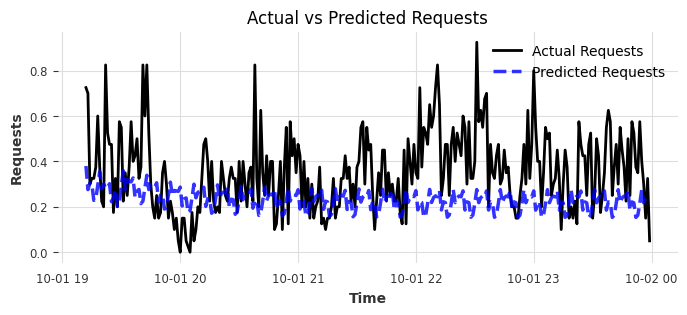

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))

test_target_pd = test_target.to_series()
pred_series_pd = pred_series.to_series()

plt.plot(test_target_pd, label="Actual Requests", linewidth=2, color="black")

# Plot predicted data with better visibility
plt.plot(pred_series_pd, label="Predicted Requests", linestyle="dashed", linewidth=2.5, color="blue", alpha=0.8)

plt.title("Actual vs Predicted Requests")
plt.xlabel("Time")
plt.ylabel("Requests")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from darts.metrics import mse, rmse, mae, mape


In [10]:
mse_score = mse(test_target, pred_series)
rmse_score = rmse(test_target, pred_series)
mae_score = mae(test_target, pred_series)

print(f"MSE: {mse_score:.4f}")
print(f"RMSE: {rmse_score:.4f}")
print(f"MAE: {mae_score:.4f}")


MSE: 0.0443
RMSE: 0.2105
MAE: 0.1658
